In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from neutrons.diffusing_neutrons import DiffusingNeutrons, Tank, Vector, Parameters
from neutrons.post_measure import Measurer
from neutrons.process.maxwell_boltzmann import MaxwellBoltzmann

/tmp/ipykernel_12826/1600687646.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def plot_trajectories(positions: list[list[Vector]], tank: None | Tank):

    radius = tank.radius
    height = tank.height
    tank_position = tank.position


    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1,1,1])
    
    if tank is not None:
        ax.plot([-radius + tank_position[0], -radius + tank_position[0]], [tank_position[1], tank_position[1]], [-height/2 + tank_position[2], height/2 + tank_position[2]], c="k")
        ax.plot([tank_position[0], tank_position[0]], [radius + tank_position[1], radius + tank_position[1]], [-height/2 + tank_position[2], height/2 + tank_position[2]], c="k")

    for position in positions:
        x = [p[0] for p in position]
        y = [p[1] for p in position]
        z = [p[2] for p in position]
        ax.plot(x, y, z, c="k", linewidth=1, alpha=0.5)

    ax.plot(0, 0, 0, "o", c="r")
    ax.set_xlabel("$x(m)$", fontsize=16)
    ax.set_ylabel("$y(m)$", fontsize=16)
    ax.set_box_aspect(aspect=None, zoom=0.9)
    ax.set_zlabel("$z(m)$", fontsize=16)
    ax.set_title("Neutron trajectories")
    ax.set_xlim(-0.4, 0.4)
    ax.set_ylim(-0.4, 0.4)
    
    if tank is not None:
        ax.plot([0 + tank_position[0], 0 + tank_position[0]], [-radius + tank_position[1], -radius + tank_position[1]], [-height/2 + tank_position[2], height/2 + tank_position[2]], c="k")
        ax.plot([radius + tank_position[0], radius + tank_position[0]], [0 + tank_position[1], 0 + tank_position[1]], [-height/2 + tank_position[2], height/2 + tank_position[2]], c="k")
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, height, 100)
        x = radius * np.outer(np.cos(u), np.ones_like(v)) + tank_position[0]
        y = radius * np.outer(np.sin(u), np.ones_like(v)) + tank_position[1]
        z = np.outer(np.ones_like(u), v) - height/2 + tank_position[2]  # Adjust the height of the cylinder
        ax.plot_surface(x, y, z, color="C0", alpha=0.2)
    plt.show()

In [3]:
cross_data_t =  [pd.read_csv("../data/h_cross_t.txt", sep=r"\s+"), pd.read_csv("../data/o_cross_t.txt", sep=r"\s+")]
cross_data_s =  [pd.read_csv("../data/h_cross_s.txt", sep=r"\s+"), pd.read_csv("../data/o_cross_s.txt", sep=r"\s+")]
cross_data_a =  [pd.read_csv("../data/h_cross_a.txt", sep=r"\s+"), pd.read_csv("../data/o_cross_a.txt", sep=r"\s+")]
spectrum_data = pd.read_csv("../data/neutron_spectrum_normalized.txt", sep=",")

params = Parameters(
            cross_data_t, 
            cross_data_s, 
            cross_data_a,
            spectrum_data,
            nNeutrons=10, 
            radius_tank=0.225, 
            height_tank=0.85, 
            position_tank=np.array([0, 0, -0.175])
            )

  0%|          | 0/10 [00:00<?, ?it/s]

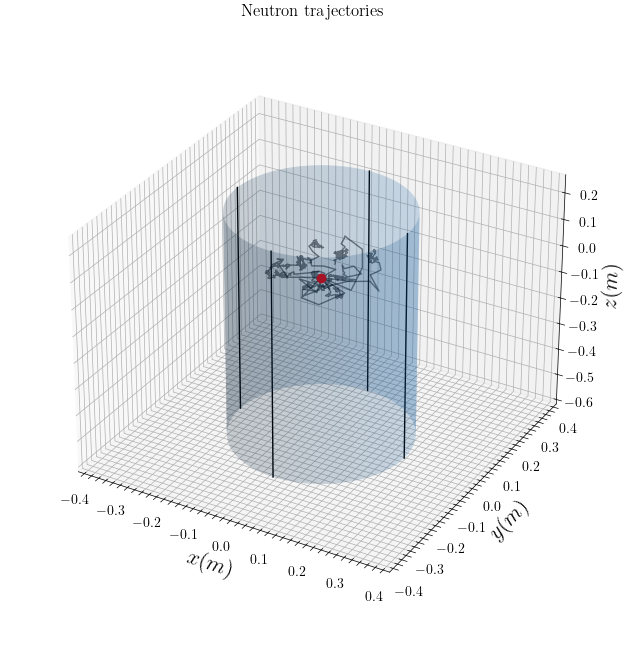

10 0


In [15]:
params.nNeutrons = 10000
diffusing_neutrons = DiffusingNeutrons(params)
diffusing_neutrons.diffuse(nCollisions=1000000)

measure = Measurer(diffusing_neutrons)
plot_trajectories(measure.positions(), diffusing_neutrons.tank)

print(measure.number_absorbed(), measure.number_escaped())

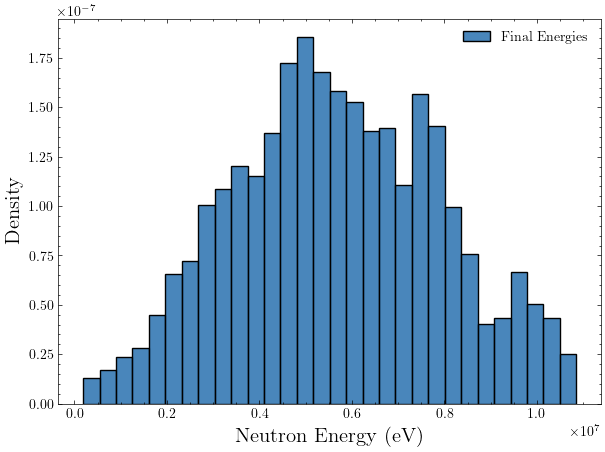

In [5]:
initial_energies = [energies[0] for energies in measure.energies()]
plt.figure(figsize= (7, 5))
sns.histplot(sorted(initial_energies), bins=30,stat="density", label="Final Energies", color="C0")
plt.ylabel("Density", fontsize=15)
plt.xlabel("Neutron Energy (eV)", fontsize=15)
plt.legend()
plt.show()

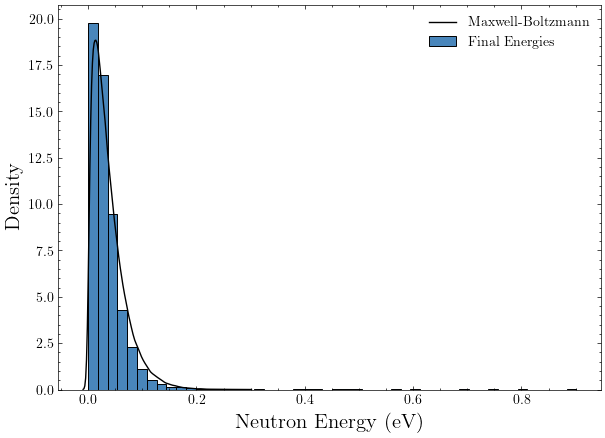

In [6]:
mw = MaxwellBoltzmann()

final_energies = [energies[-1] for energies in measure.energies()]
mw_energies = [mw.thermal_energy() for _ in range(100000)]
plt.figure(figsize= (7, 5))
sns.kdeplot(mw_energies, label="Maxwell-Boltzmann", color="k")
sns.histplot(sorted(final_energies)[:-measure.number_escaped()], bins=50,stat="density", label="Final Energies", color="C0")
#plt.xlim(0, 0.25)
plt.ylabel("Density", fontsize=15)
plt.xlabel("Neutron Energy (eV)", fontsize=15)
plt.legend()
plt.show()

In [7]:
params.nNeutrons = 10000
diffusing_neutrons = DiffusingNeutrons(params)
diffusing_neutrons.diffuse(nCollisions=5000)

  0%|          | 0/14 [00:00<?, ?it/s]

In [8]:
measure = Measurer(diffusing_neutrons)

print(f"Total: {measure.number_total()}")
print(f"Thermal: {measure.number_thermal()}")
print(f"Absorbed: {measure.number_absorbed()}")
print(f"Escaped: {measure.number_escaped()}")


Total: 10000
Thermal: 9748
Absorbed: 9808
Escaped: 192


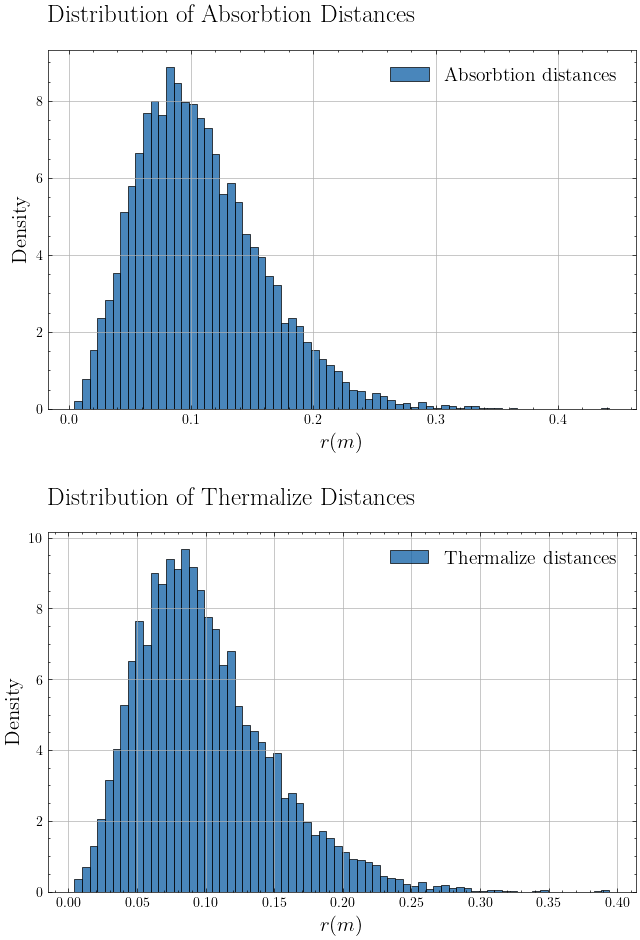

In [9]:
fig, axs = plt.subplots(2, figsize=(7, 10))

sns.histplot(measure.absorbed_distances(), label="Absorbtion distances", bins=70, stat="density", ax=axs[0])
axs[0].set_ylabel("Density", fontsize=15)
axs[0].set_xlabel("$r (m)$", fontsize=15)
#axs[0].set_xlim(0, diffusing_neutrons.tank.radius+0.01)
axs[0].grid(True)
axs[0].set_title("Distribution of Absorbtion Distances", fontsize=18, pad=20, loc="left")
axs[0].legend(fontsize=14)

sns.histplot(measure.thermalize_distances(), label="Thermalize distances", bins=70, stat="density", ax=axs[1])
axs[1].set_ylabel("Density", fontsize=15)
axs[1].set_xlabel("$r (m)$", fontsize=15)
#axs[1].set_xlim(0, diffusing_neutrons.tank.radius+0.01)
axs[1].grid(True)
axs[1].set_title("Distribution of Thermalize Distances", fontsize=18, pad=20, loc="left")
axs[1].legend(fontsize=14)

plt.tight_layout(pad=2.5)
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

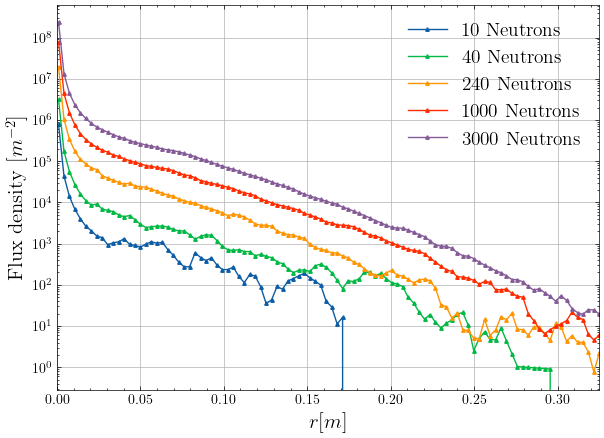

In [10]:
plt.figure(figsize= (7, 5))

for n in [10, 40, 240, 1000, 3000]:
    params.nNeutrons = n
    diffusing_neutrons = DiffusingNeutrons(params)
    diffusing_neutrons.diffuse(nCollisions=5000)
    measure = Measurer(diffusing_neutrons)
    radii = np.linspace(0.001, diffusing_neutrons.tank.radius+0.1, 100)
    fluxes = [measure.flux(r) for r in radii]

    plt.plot(radii, fluxes, "-^", markersize=2.5, label = f"{n} Neutrons")
plt.ylabel("Flux density [$m^{-2}$]", fontsize=15)
plt.xlabel("$r [m]$", fontsize=15)
plt.grid(True)
plt.yscale("log")
plt.xlim(0, diffusing_neutrons.tank.radius+0.1)
plt.legend(fontsize=14)
plt.show()